(268, 268)


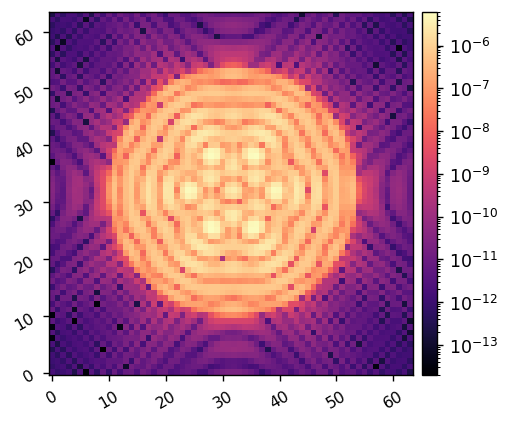

In [18]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from poppy_roman_cgi_phasec import cgi
from wfsc import iefc_1dm as iefc
from wfsc import utils

import misc

reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
#               use_opds=True,
             )

npsf = hlc.npsf
Nact = hlc.Nact

ref_psf = hlc.calc_psf()

misc.myimshow(ref_psf.intensity, lognorm=True)

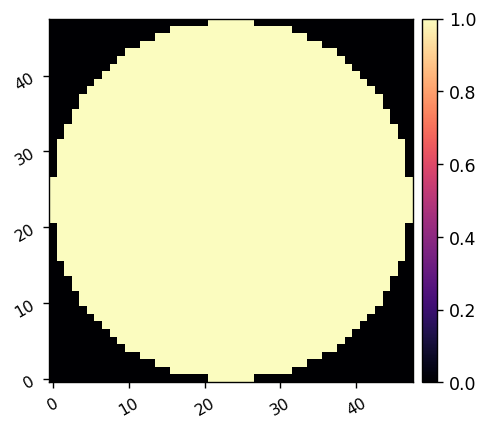

1780.0

In [29]:
misc.myimshow(hlc.dm_mask)
hlc.dm_mask.sum()

# Create dark hole ROI to calibrate and control

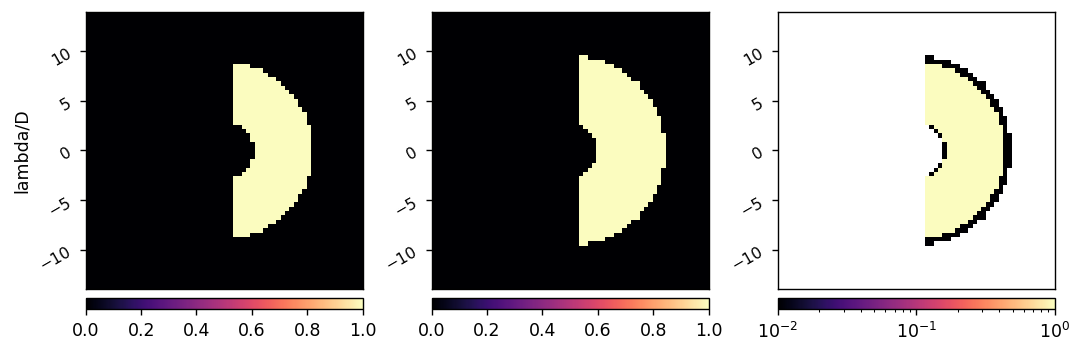

In [12]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlc.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 9
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
}
control_mask = utils.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow3(dh_mask.reshape(npsf,npsf),
               control_mask.reshape(npsf,npsf), 
               weights.reshape(npsf,npsf),
               lognorm3=True,
               pxscl1=hlc.psf_pixelscale_lamD, pxscl2=hlc.psf_pixelscale_lamD, pxscl3=hlc.psf_pixelscale_lamD)


# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 296


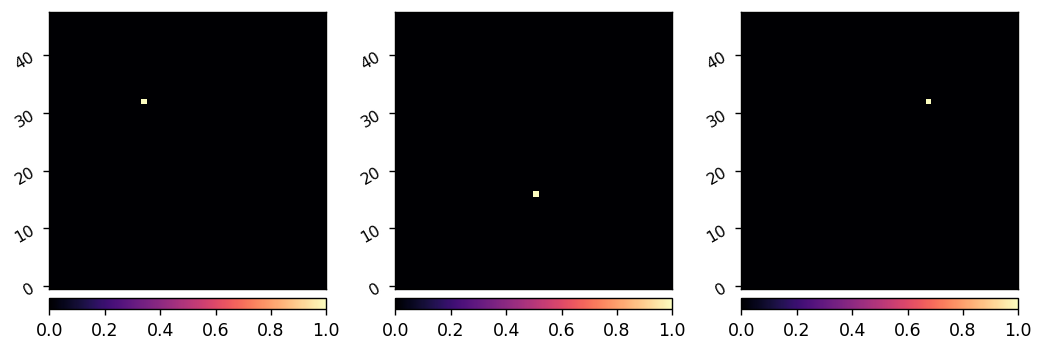

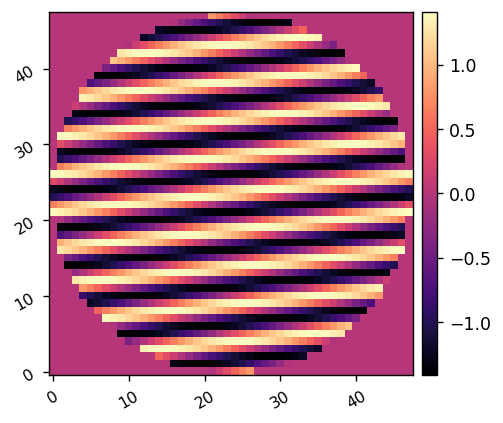

In [13]:
probe_modes = iefc.create_probe_poke_modes(Nact, 
                                           xinds=[Nact//3, Nact//2, 2*Nact//3],
                                           yinds=[2*Nact//3, Nact//3, 2*Nact//3])

calibration_modes, fx, fy = iefc.create_fourier_modes(xfp, 
                                                      control_mask.reshape((npsf,npsf)), 
                                                      Nact, 
                                                      circular_mask=False)
calibration_modes[:] *= hlc.dm_mask.flatten()


calibration_amplitude = 0.006 * hlc.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * hlc.wavelength_c.to(u.m).value
nmodes = calibration_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))

misc.myimshow3(probe_modes[0], probe_modes[1], probe_modes[2])
misc.myimshow(calibration_modes[0].reshape(Nact,Nact))

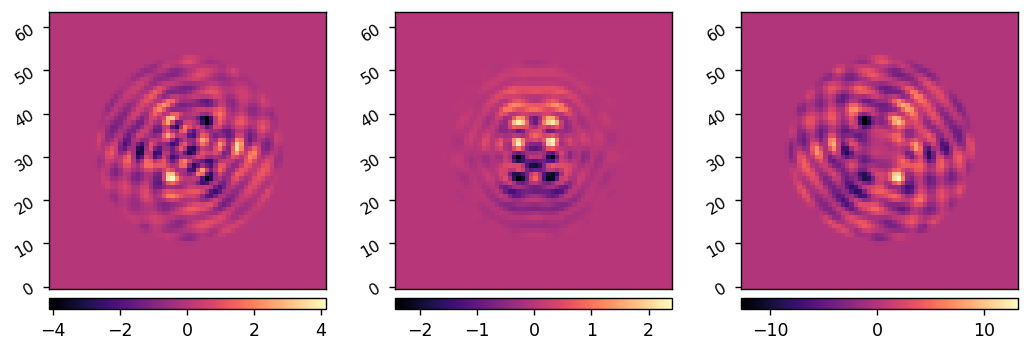

In [20]:
reload(iefc)
hlc.reset_dms()
differential_images, single_images = iefc.take_measurement(hlc, probe_modes, probe_amplitude, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [21]:
reload(iefc)
response_cube, calibration_cube = iefc.calibrate(hlc, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 296 in 3.261s
	Calibrated mode 2 / 296 in 6.508s
	Calibrated mode 3 / 296 in 9.908s
	Calibrated mode 4 / 296 in 13.178s
	Calibrated mode 5 / 296 in 16.438s
	Calibrated mode 6 / 296 in 19.711s
	Calibrated mode 7 / 296 in 22.983s
	Calibrated mode 8 / 296 in 26.246s
	Calibrated mode 9 / 296 in 29.509s
	Calibrated mode 10 / 296 in 32.778s
	Calibrated mode 11 / 296 in 36.051s
	Calibrated mode 12 / 296 in 39.323s
	Calibrated mode 13 / 296 in 42.594s
	Calibrated mode 14 / 296 in 45.852s
	Calibrated mode 15 / 296 in 49.221s
	Calibrated mode 16 / 296 in 52.485s
	Calibrated mode 17 / 296 in 55.751s
	Calibrated mode 18 / 296 in 59.017s
	Calibrated mode 19 / 296 in 62.280s
	Calibrated mode 20 / 296 in 65.536s
	Calibrated mode 21 / 296 in 68.801s
	Calibrated mode 22 / 296 in 72.057s
	Calibrated mode 23 / 296 in 75.314s
	Calibrated mode 24 / 296 in 78.572s
	Calibrated mode 25 / 296 in 81.837s
	Calibrated mode 26 / 296 in 85.090s
	Calibrated mode 27 / 296 in 

	Calibrated mode 215 / 296 in 712.519s
	Calibrated mode 216 / 296 in 715.830s
	Calibrated mode 217 / 296 in 719.137s
	Calibrated mode 218 / 296 in 722.456s
	Calibrated mode 219 / 296 in 725.857s
	Calibrated mode 220 / 296 in 729.170s
	Calibrated mode 221 / 296 in 732.471s
	Calibrated mode 222 / 296 in 735.780s
	Calibrated mode 223 / 296 in 739.087s
	Calibrated mode 224 / 296 in 742.396s
	Calibrated mode 225 / 296 in 745.705s
	Calibrated mode 226 / 296 in 749.011s
	Calibrated mode 227 / 296 in 752.317s
	Calibrated mode 228 / 296 in 755.631s
	Calibrated mode 229 / 296 in 758.941s
	Calibrated mode 230 / 296 in 762.247s
	Calibrated mode 231 / 296 in 765.554s
	Calibrated mode 232 / 296 in 768.963s
	Calibrated mode 233 / 296 in 772.278s
	Calibrated mode 234 / 296 in 775.592s
	Calibrated mode 235 / 296 in 778.904s
	Calibrated mode 236 / 296 in 782.235s
	Calibrated mode 237 / 296 in 785.555s
	Calibrated mode 238 / 296 in 788.901s
	Calibrated mode 239 / 296 in 792.253s
	Calibrated mode 240 / 29

In [13]:
fname = 'hlc_39'

dshaped_Yopds_polaxis0_iwa3.0_owa9.0


In [22]:
misc.save_pickle(data_dir/'response-data'/fname, response_cube)
misc.save_pickle(data_dir/'calibration-data'/fname, calibration_cube)

NameError: name 'data_dir' is not defined

In [143]:
response_cube = iefcu.load_pickle(data_dir/'response-data'/fname)
calibration_cube = iefcu.load_pickle(data_dir/'calibration-data'/fname)

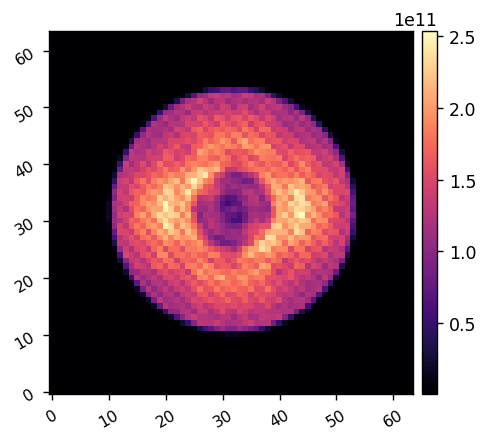

In [24]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [26]:
reload(iefc)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, weights.flatten(), 
                                               rcond=1e-2, 
                                               nprobes=probe_modes.shape[0], pca_modes=None)

Using Weighted Least Squares 


# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 15


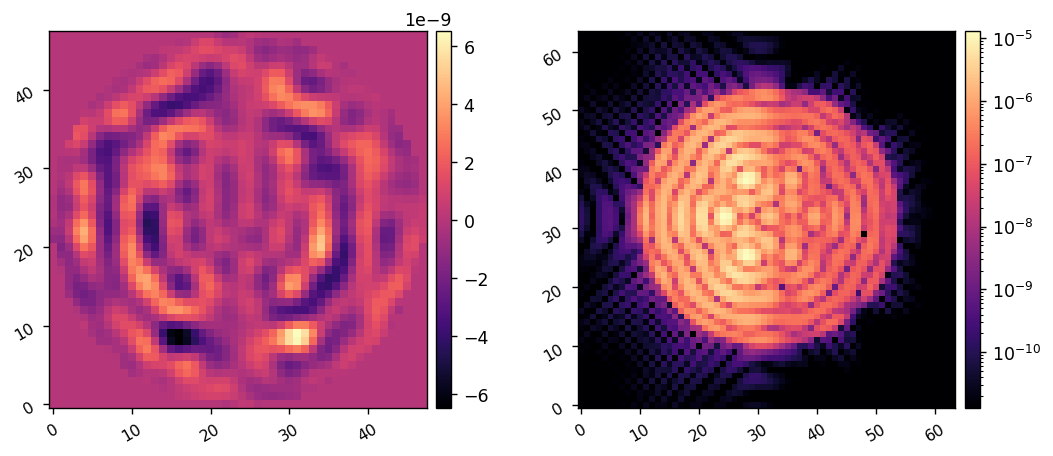

	Closed-loop iteration 2 / 15


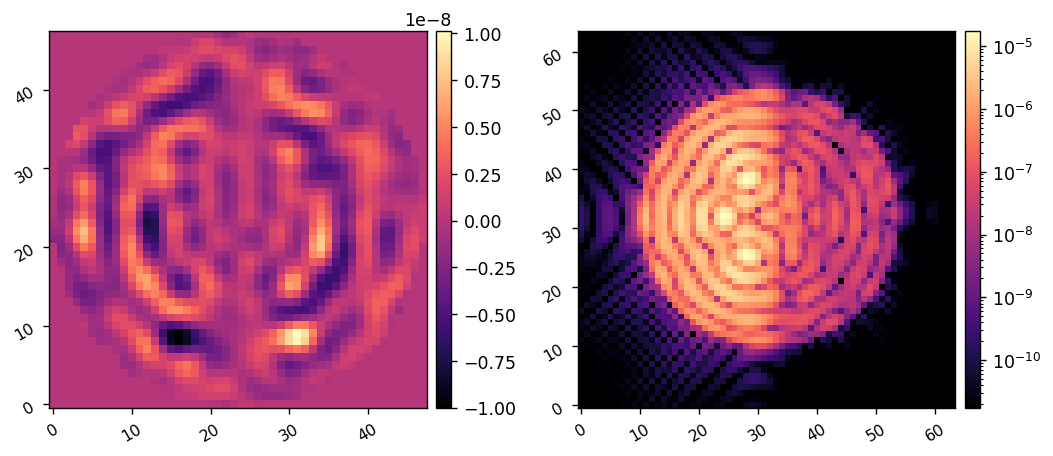

	Closed-loop iteration 3 / 15


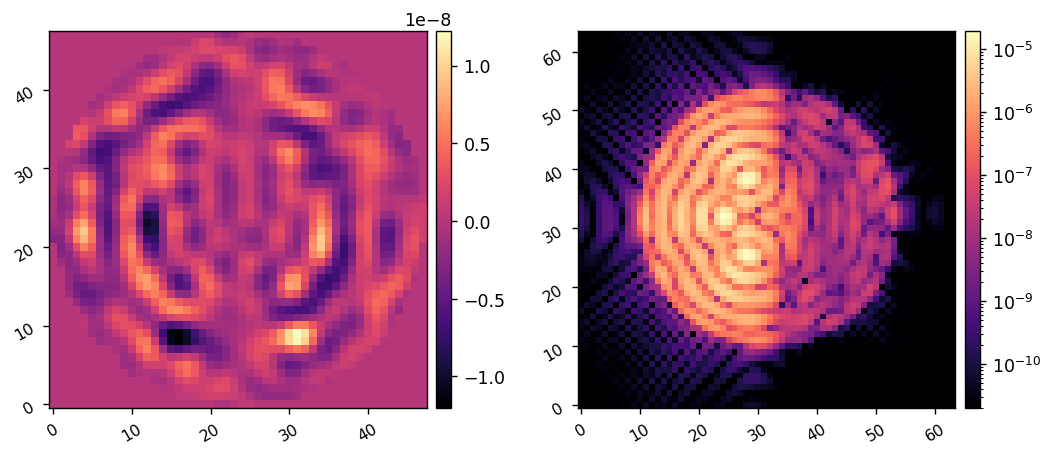

	Closed-loop iteration 4 / 15


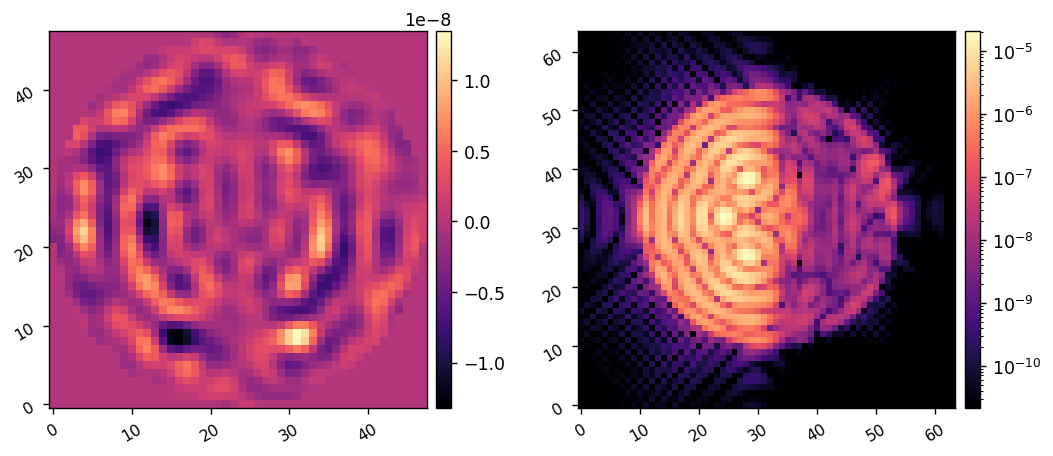

	Closed-loop iteration 5 / 15


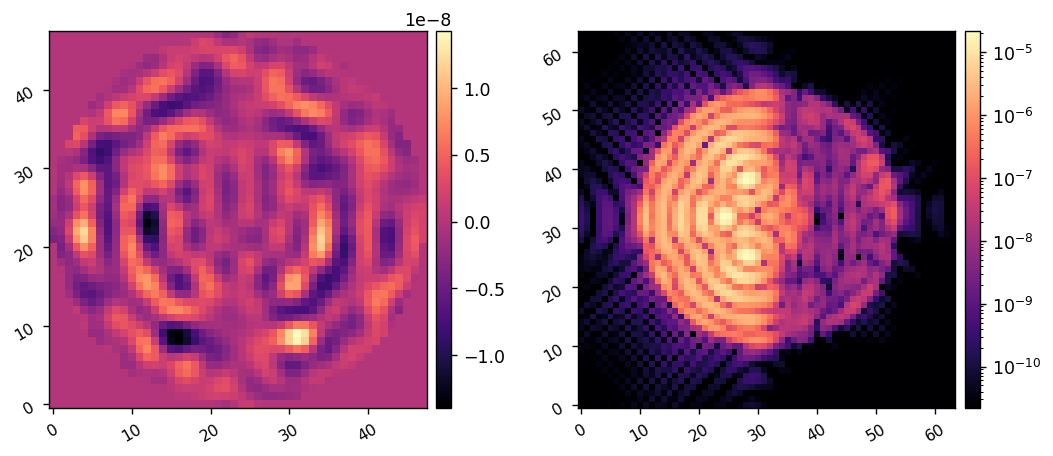

	Closed-loop iteration 6 / 15


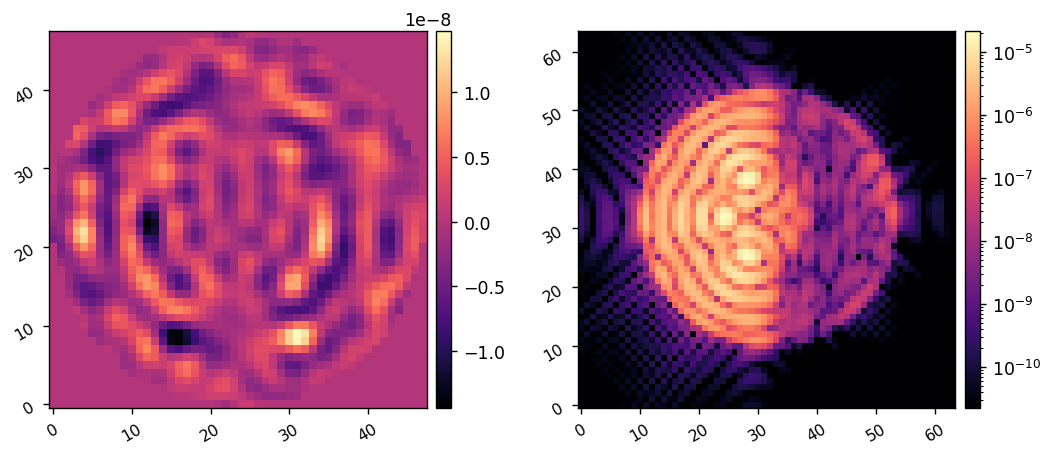

	Closed-loop iteration 7 / 15


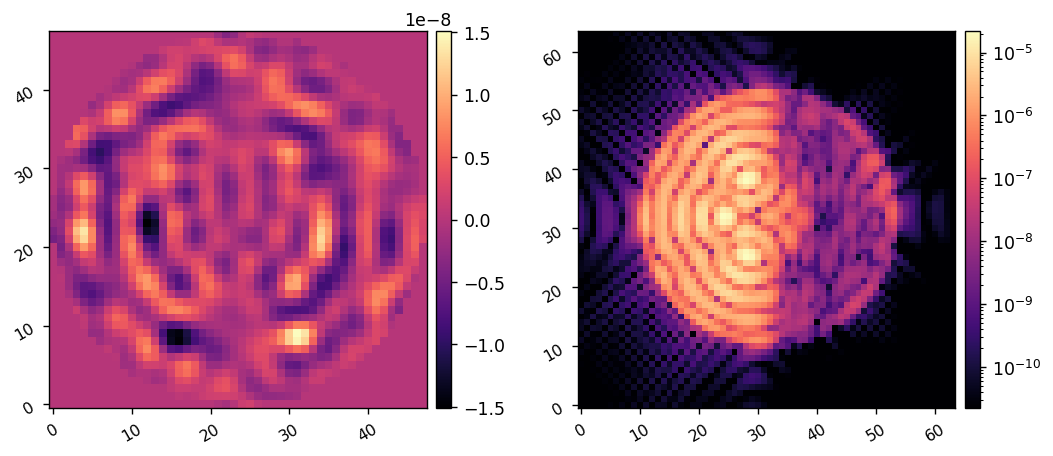

	Closed-loop iteration 8 / 15


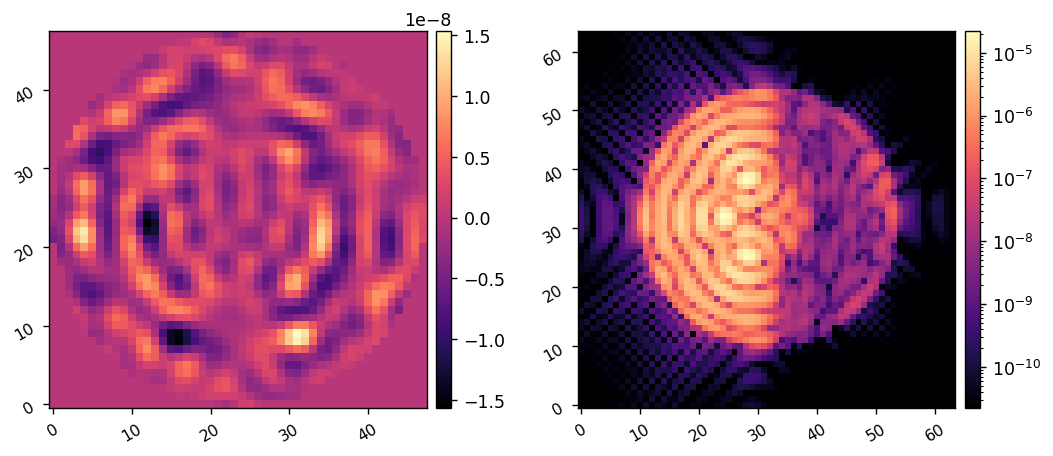

	Closed-loop iteration 9 / 15


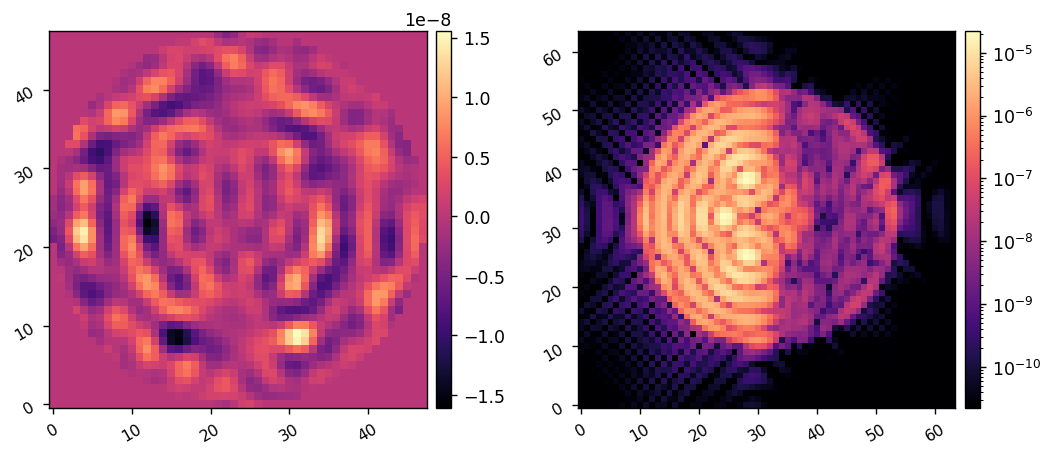

	Closed-loop iteration 10 / 15


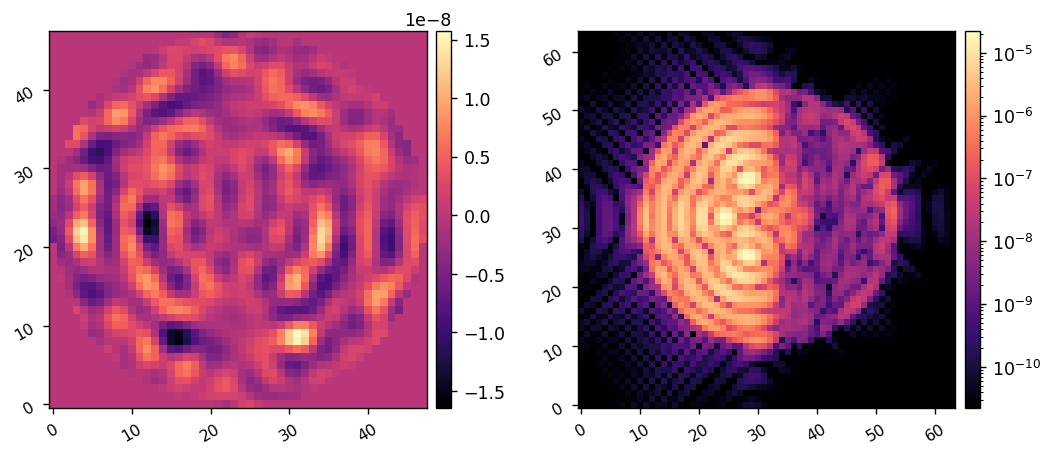

	Closed-loop iteration 11 / 15


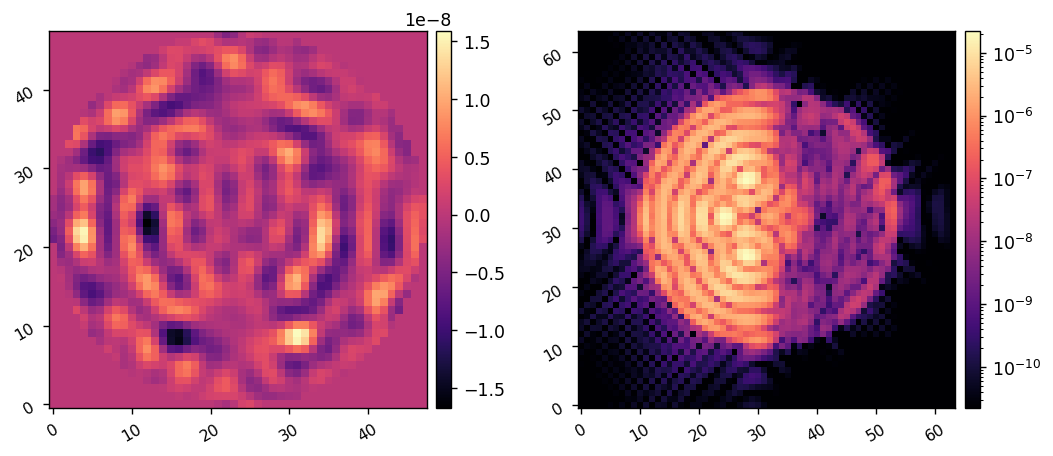

	Closed-loop iteration 12 / 15


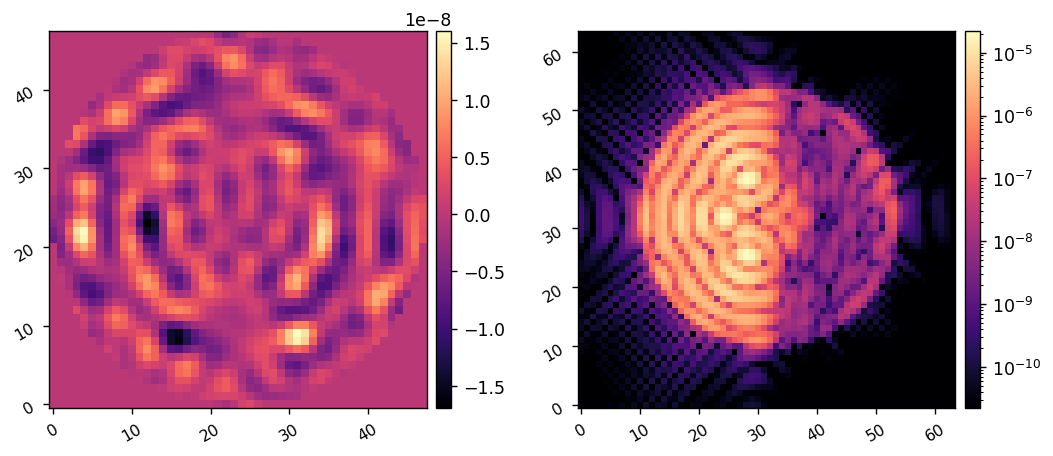

	Closed-loop iteration 13 / 15


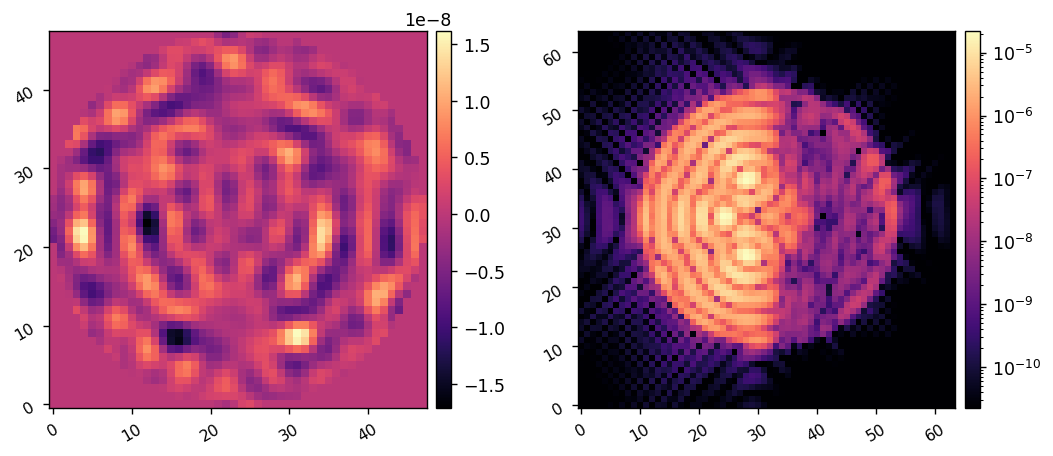

	Closed-loop iteration 14 / 15


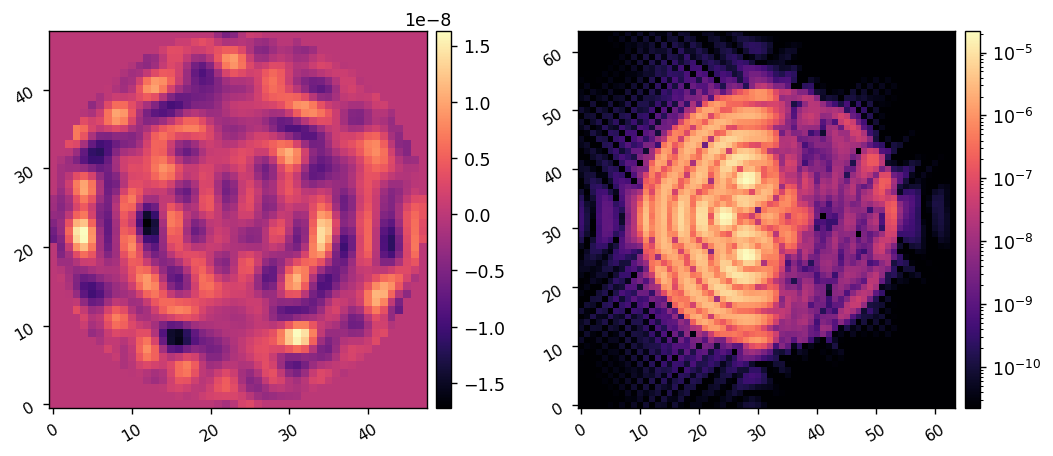

	Closed-loop iteration 15 / 15


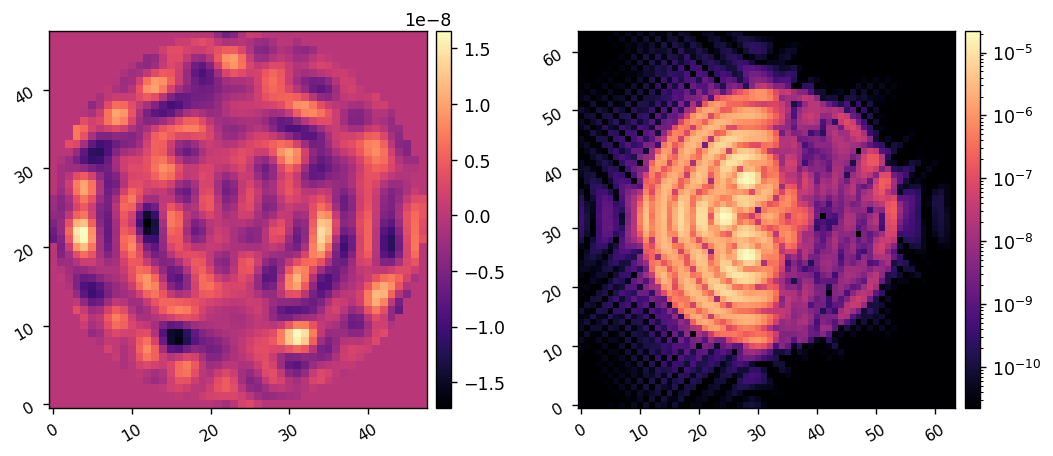

I-EFC loop completed in 37.331s.


In [28]:
reload(iefc)
images, dm_commands = iefc.run(hlc, 
                               control_matrix, 
                               probe_modes, 
                               probe_amplitude, 
                               calibration_modes, 
                               weights, 
                               num_iterations=15, gain=-0.5, leakage=0.0,
                               display=True)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
